In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import rankdata, zscore
from matplotlib.lines import Line2D
from matplotlib.patches import PathPatch

In [2]:
def get_rep_ranks(data):
    ranks = rankdata(data,method="max",axis=1)
    num_terms = ranks.shape[1]
    rep_ranks = []
    for idx in range(ranks.shape[0]):
        rep_rank = 1 / ((num_terms -ranks[idx,idx])+1)
        rep_ranks.append(rep_rank)
    return rep_ranks

def get_ranks(data):
    ranks = rankdata(data,method="max",axis=1)
    num_terms = ranks.shape[1]
    ranks_ = []
    for idx in range(ranks.shape[0]):
        rank_tmp = ((num_terms -ranks[idx,idx])+1)
        ranks_.append(rank_tmp)
    return ranks_

def get_values(data):
    values = []
    for idx in range(data.shape[0]):
        values.append(data[idx,idx])
    return values

def get_zscores(data):
    zscores = []
    for idx in range(data.shape[0]):
        v1 = data[idx,:]
        v2 = data[:,idx]
        z = np.sqrt(np.maximum(0, zscore(data[idx,:])[idx])**2 + np.maximum(0,zscore(data[:,idx])[idx])**2) 
        zscores.append(z)
    return zscores

def adjust_box_widths(g, fac):
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

In [4]:
def make_plot(network,task,score,figname):
    results_tmp = []
    for features in ["emb","adj","allemb"]:
        if features == "emb":
            featname = "N2V (human+model)"
        elif features == "adj":
            featname = "AdjMat (human+model)"
        elif features == "allemb":
            featname = "N2V (all-species)"
        for apair in ["ce_hs","dm_hs","dr_hs","hs_mm","hs_sc"]:
            if apair.split("_")[0] in ["ce","dm","dr"]:
                other_spec = apair.split("_")[0]
            else:
                other_spec = apair.split("_")[1]
            try:
                # fp_data = "/Users/christophermancuso/Desktop/project_data/cross_species/cross_species_tmp/bothterms_weights/"
                fp_data = "../results/bothterms_weights/"
                if task == "CosSim":
                    data_tmp = np.load(fp_data+f"CosSims__GO__{apair}__{network}__{features}.npy")
                elif task == "log2p_hs":
                    data_tmp = np.load(fp_data+f"Log2P_hs_to_{other_spec}__GO__{apair}__{network}__{features}.npy")
                elif task == "log2p_other":
                    data_tmp = np.load(fp_data+f"Log2P_{other_spec}_to_hs__GO__{apair}__{network}__{features}.npy")
                elif task == "auroc_hs":
                    data_tmp = np.load(fp_data+f"auROC_hs_to_{other_spec}__GO__{apair}__{network}__{features}.npy")
                elif task == "auroc_other":
                    data_tmp = np.load(fp_data+f"auROC_{other_spec}_to_hs__GO__{apair}__{network}__{features}.npy")
                rep_ranks = get_rep_ranks(data_tmp)
                ranks = get_ranks(data_tmp)
                if score == "raw":
                    values = get_values(data_tmp)
                elif score == "zscore":
                    values = get_zscores(data_tmp)
                for idx in range(len(rep_ranks)):
                    results_tmp.append([apair,featname,rep_ranks[idx],ranks[idx],values[idx]])
            except FileNotFoundError:
                pass
    df = pd.DataFrame(results_tmp,columns=["Species","Feature","Rep_rank","Rank","Values"])
#     print(df.tail())
    fig, ax = plt.subplots(2,4,figsize=(12,6))
    for idx2, apair in enumerate(["hs_mm","dm_hs","ce_hs","hs_sc"]):
        data_plot = df[df["Species"]==apair]
        sns.boxplot(data=data_plot,x="Species",y="Values",hue="Feature",orient="v",
                    showfliers=False,notch=True,ax=ax[0,idx2],
                    palette=["orange","mediumblue","deepskyblue"],
                    hue_order=["N2V (all-species)","N2V (human+model)","AdjMat (human+model)"])
        ax[0,idx2].get_legend().remove()
        ax[0,idx2].set_ylabel("")
        ax[0,idx2].set_xlabel("")
        ax[0,idx2].set_xticklabels("")
        ax[0,idx2].set_xticks([])
        ax[0,idx2].axhline(ls="--")
        pair_map = {"ce_hs":"worm","dm_hs":"fly",
                    "hs_mm":"mouse","hs_sc":"yeast"}
        bins_ = [1,2,3,4,5,80]
        data_adj = data_plot[data_plot["Feature"]=="AdjMat (human+model)"]["Rank"].to_numpy()
        h_adj=np.histogram(data_adj,bins=bins_)
        data_emb = data_plot[data_plot["Feature"]=="N2V (human+model)"]["Rank"].to_numpy()
        h_emb=np.histogram(data_emb,bins=bins_)
        data_allemb = data_plot[data_plot["Feature"]=="N2V (all-species)"]["Rank"].to_numpy()
        h_allemb=np.histogram(data_allemb,bins=bins_)
        xlab=['1','2','3','4','>5']
        data_df = []
        for idxdata in range(len(xlab)):
            data_df.append([xlab[idxdata],h_emb[0][idxdata],"N2V (human+model)"])
            data_df.append([xlab[idxdata],h_adj[0][idxdata],"AdjMat (human+model)"])
            data_df.append([xlab[idxdata],h_allemb[0][idxdata],"N2V (all-species)"])
        data_df = pd.DataFrame(data_df,columns=['Rank of Matching Term',"Counts","Feature"])
        sns.barplot(data=data_df,x="Rank of Matching Term",y="Counts",hue="Feature",ax=ax[1,idx2],
                    palette=["orange","mediumblue","deepskyblue"],
                    hue_order=["N2V (all-species)","N2V (human+model)","AdjMat (human+model)"])
#         ax[1,idx2].get_legend().remove()
        ax[1,idx2].set_ylabel("")
        if "log2p" in task:
            ax[0,0].set_ylabel(f"log2(auPRC/prior)")
        elif "auroc" in task:
            ax[0,0].set_ylabel(f"auroc")
        elif "CosSim" in task:
            ax[0,0].set_ylabel(f"cosine similarity")
        ax[1,0].set_ylabel("Number of Terms")
        tmpstr = pair_map[apair]
        ax[1,idx2].set_xlabel("Rank of Matching Term \n\n " + r"$\bf{" + tmpstr +"}$")
        if idx2 == 0:
            ax[1,idx2].get_legend().remove()
        else:    
            ax[1,idx2].get_legend().remove()
    if "hs" in task:
        fig.suptitle("Train model using only human genes and predict genes in other species",fontweight="bold")
    elif "other" in task:
        fig.suptitle("Train model using only other species genes and predict genes in human",fontweight="bold")
    elif "CosSim" in task:
        fig.suptitle("Cosine similarities of model weights",fontweight="bold")
    # make a legend
    handles = [Line2D([0], [0], color="orange", lw=4),
               Line2D([0], [0], color="mediumblue", lw=4),
               Line2D([0], [0], color="deepskyblue", lw=4)]
    labels = ["NV2 (all-species)","N2V (human-model)", "AdjMat (human-model)"]
    fig.legend(handles,labels,ncol=3,loc="center",bbox_to_anchor=(0.5,0.025),frameon=False)
    plt.subplots_adjust(bottom=0.18,hspace=0.05,wspace=0.24,top=0.93)
#     plt.tight_layout()
    adjust_box_widths(fig, 0.8)
    fig.savefig(f'../figures/{figname}')
    

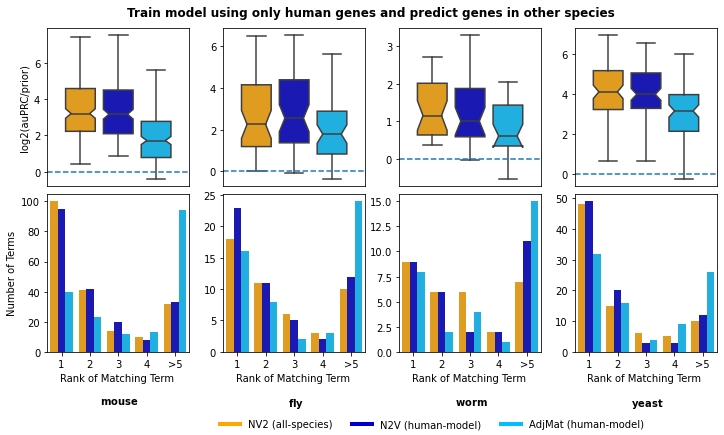

In [5]:
network = "IMP"
score = "raw"
task = "log2p_hs"
fig_name = "Fig4.pdf"
make_plot(network,task,score,fig_name)

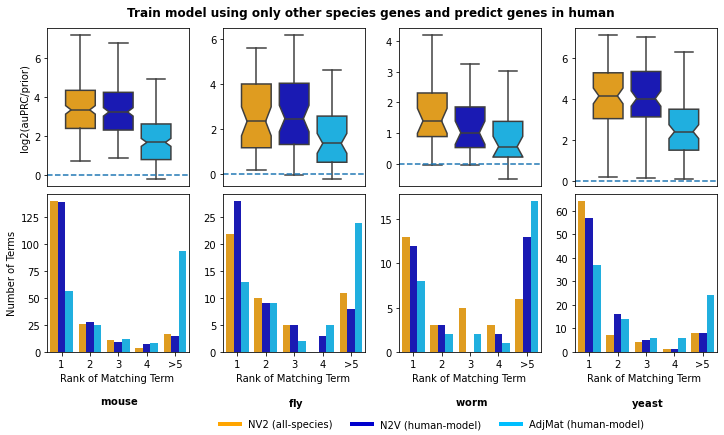

In [6]:
network = "IMP"
score = "raw"
task = "log2p_other"
fig_name = "FigSM7.pdf"
make_plot(network,task,score,fig_name)

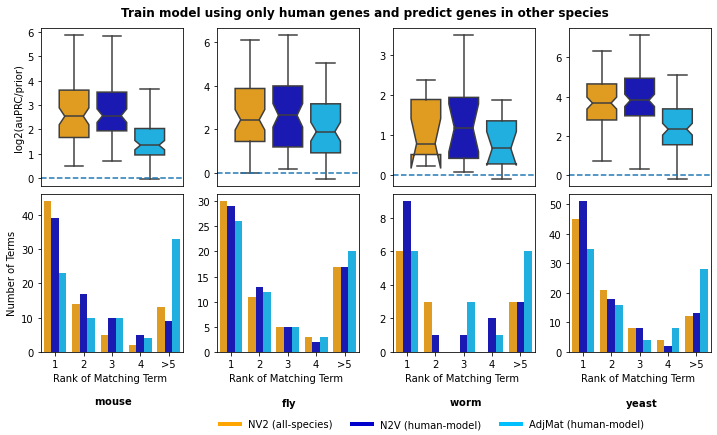

In [7]:
network = "BioGRID"
score = "raw"
task = "log2p_hs"
fig_name = "FigSM8.pdf"
make_plot(network,task,score,fig_name)

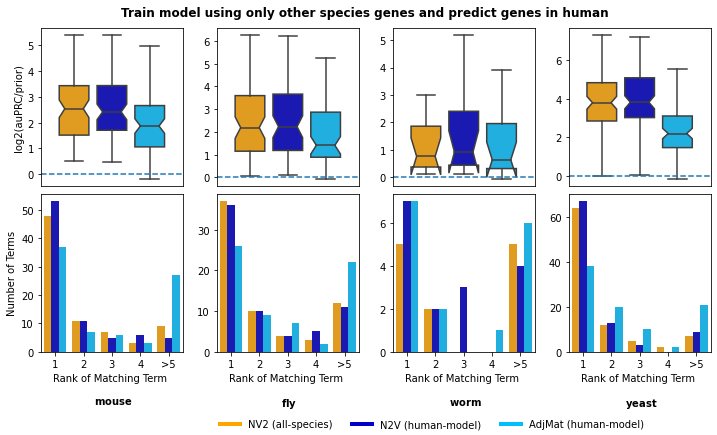

In [8]:
network = "BioGRID"
score = "raw"
task = "log2p_other"
fig_name = "FigSM9.pdf"
make_plot(network,task,score,fig_name)